#### I will find more data and update soon.

In [1]:
from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import os
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
np.random.seed(123)

In [4]:
#No module named 'numba.decorators'
#conda install -c numba numba
#conda install -c conda-forge librosa

#cannot load library libsndfile64bit.dll 
#pip uninstall soundfile
#pip install soundfile

In [5]:
audio_dir = 'Respiratory_Sound_Database/audio_and_txt_files'
wav_files = [os.path.join(audio_dir, f) for f in os.listdir(audio_dir) if f.endswith('.wav')]

In [6]:
directory = audio_dir
count = 0

for file in os.listdir(directory):
    if file.endswith(".wav"):
        count += 1

print(f"Number of .wav files in directory: {count}")

Number of .wav files in directory: 920


In [7]:
n_mels = 128
max_sec = 6

all_mel_spec = []
for wav_file in wav_files:
    samples, sample_rate = librosa.load(wav_file, duration=max_sec)
    mel_spec = librosa.feature.melspectrogram(y=samples, sr=sample_rate, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    all_mel_spec.append(log_mel_spec)

X_train = np.array(all_mel_spec)
X_train = np.expand_dims(X_train, axis=-1)

X_train.shape

(920, 128, 259, 1)

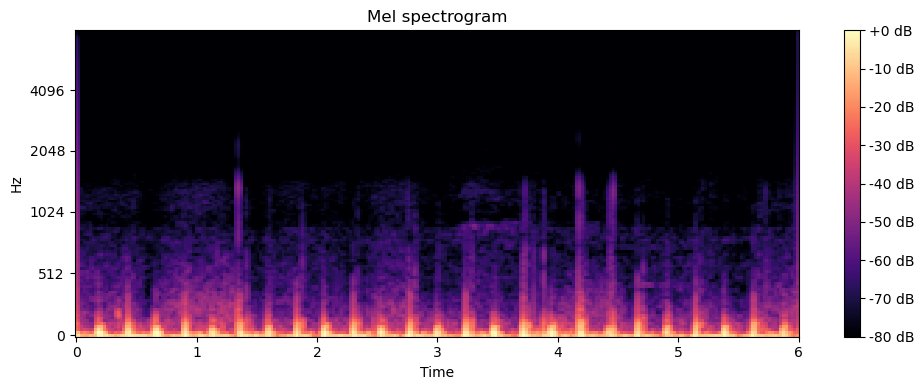

In [8]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(all_mel_spec[0], y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

In [9]:
y_train = pd.read_csv("Respiratory_Sound_Database/patient_diagnosis.csv" ,  header=None)
y_train = y_train.rename(columns={0: "id", 1: "type"})
y_train.loc[y_train['type'] != 'Healthy', 'type'] = 'Unhealthy'
y_train

,id,type
0,101,Unhealthy
1,102,Healthy
2,103,Unhealthy
3,104,Unhealthy
4,105,Unhealthy
...,...,...
121,222,Unhealthy
122,223,Unhealthy
123,224,Healthy
124,225,Healthy


In [10]:
y_train["type"].value_counts()

Unhealthy    100
Healthy       26
Name: type, dtype: int64

In [11]:
patient_ids = [int(f.split("_")[0]) for f in os.listdir(audio_dir) if f.endswith(".wav")]
new_y_train = pd.DataFrame({'id': patient_ids})
for i, pid in enumerate(patient_ids):
    match = y_train['id'] == pid
    if match.any():
        new_y_train.at[i, 'type'] = y_train[match]['type'].values[0]
    else:
        new_y_train.at[i, 'type'] = 'Unknown'
new_y_train

,id,type
0,101,Unhealthy
1,101,Unhealthy
2,102,Healthy
3,103,Unhealthy
4,104,Unhealthy
...,...,...
915,224,Healthy
916,225,Healthy
917,226,Unhealthy
918,226,Unhealthy


In [12]:
new_y_train["type"].value_counts()

Unhealthy    885
Healthy       35
Name: type, dtype: int64

In [13]:
y_train = new_y_train
y_train["type"] = np.where(y_train["type"] == "Healthy", 0, 1)

y_train = y_train.drop("id", axis=1)
y_train = to_categorical(y_train, 2)
y_train

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [14]:
def apply_spec_augment(spectrogram, num_masks=2, freq_mask_length=27, time_mask_length=100):
    for i in range(num_masks):
        f = np.random.randint(low=0, high=spectrogram.shape[0] - freq_mask_length)
        spectrogram[f:f+freq_mask_length, :] = 0

    for i in range(num_masks):
        t = np.random.randint(low=0, high=spectrogram.shape[1] - time_mask_length)
        spectrogram[:, t:t+time_mask_length] = 0

    return spectrogram

In [15]:
X_train_aug = []
y_train_aug = []

for i in range(X_train.shape[0]):
    spectrogram = X_train[i, :, :, 0]
    for j in range(10):
        augmented_spectrogram = apply_spec_augment(spectrogram)
        X_train_aug.append(augmented_spectrogram[:, :, np.newaxis])
        y_train_aug.append(y_train[i])

X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

print("Original X_train shape:", X_train.shape)
print("Augmented X_train shape:", X_train_aug.shape)
print("Original y_train shape:", y_train.shape)
print("Augmented y_train shape:", y_train_aug.shape)

Original X_train shape: (920, 128, 259, 1)
Augmented X_train shape: (9200, 128, 259, 1)
Original y_train shape: (920, 2)
Augmented y_train shape: (9200, 2)


In [17]:
X_train = X_train_aug
y_train = y_train_aug

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=True)
X_train.shape , y_train.shape , X_val.shape, y_val.shape , X_test.shape, y_test.shape

((6256, 128, 259, 1),
 (6256, 2),
 (1104, 128, 259, 1),
 (1104, 2),
 (1840, 128, 259, 1),
 (1840, 2))

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report , confusion_matrix ,ConfusionMatrixDisplay

In [20]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
196/196 [==============================] - 58s 294ms/step - loss: 0.1886 - accuracy: 0.9597 - val_loss: 0.1048 - val_accuracy: 0.9601
Epoch 2/10
196/196 [==============================] - 60s 306ms/step - loss: 0.0849 - accuracy: 0.9679 - val_loss: 0.0572 - val_accuracy: 0.9828
Epoch 3/10
196/196 [==============================] - 61s 310ms/step - loss: 0.0548 - accuracy: 0.9784 - val_loss: 0.0400 - val_accuracy: 0.9846
Epoch 4/10
196/196 [==============================] - 62s 319ms/step - loss: 0.0386 - accuracy: 0.9864 - val_loss: 0.0334 - val_accuracy: 0.9882
Epoch 5/10
196/196 [==============================] - 61s 309ms/step - loss: 0.0379 - accuracy: 0.9867 - val_loss: 0.0289 - val_accuracy: 0.9928
Epoch 6/10
196/196 [==============================] - 61s 313ms/step - loss: 0.0320 - accuracy: 0.9904 - val_loss: 0.0200 - val_accuracy: 0.9946
Epoch 7/10
196/196 [==============================] - 61s 310ms/step - loss: 0.0255 - accuracy: 0.9938 - val_loss: 0.0204 - val_ac

In [23]:
score = model.evaluate(X_test,y_test)
print("accuracy : " + str(score[1] * 100) )

58/58 [==============================] - 5s 84ms/step - loss: 0.0288 - accuracy: 0.9935
accuracy : 99.34782385826111


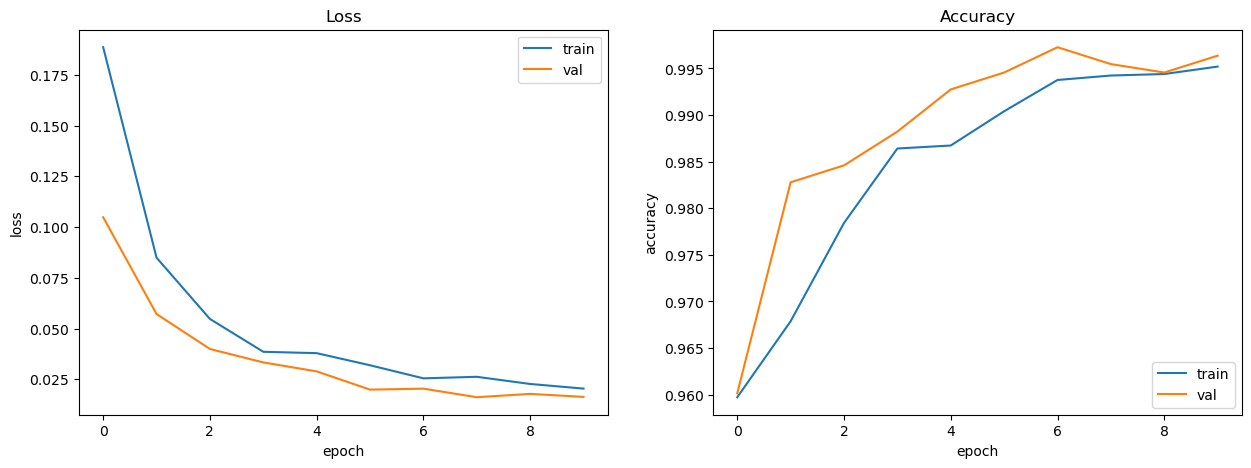

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2 , figsize=(15,5))

ax1.set_title('Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'val'], loc='upper right')


ax2.set_title('Accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train', 'val'], loc='lower right')

58/58 [==============================] - 5s 80ms/step


[Text(0.5, 0, 'Predictions'), Text(0, 0.5, 'Actuals')]

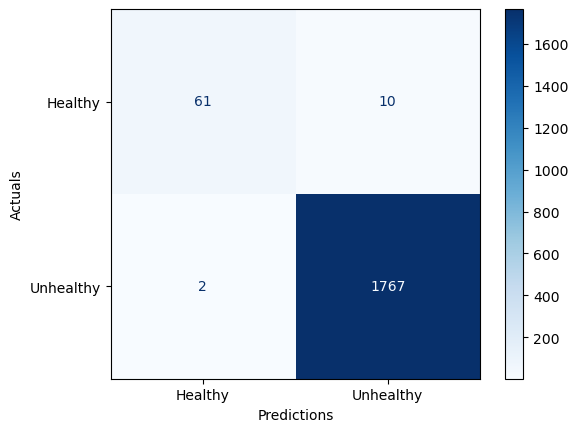

In [25]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)
cm = confusion_matrix(y_true, y_pred_classes) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Healthy" , "Unhealthy"])
disp.plot(cmap='Blues')
disp.ax_.set(xlabel='Predictions', ylabel='Actuals')

In [26]:
print(classification_report(y_true , y_pred_classes, target_names=["Healthy" , "Unhealthy"]))

              precision    recall  f1-score   support

     Healthy       0.97      0.86      0.91        71
   Unhealthy       0.99      1.00      1.00      1769

    accuracy                           0.99      1840
   macro avg       0.98      0.93      0.95      1840
weighted avg       0.99      0.99      0.99      1840

